# Вводные

## Цель работы

изучение методов кластеризации

## Задание 

1. Выбрать массив данных (рекомендуются базы по ссылкам No 3-4 из 
списка  литературы),  описать  параметры.  Примечание:  тип  задачи 
«классификация», «кластеризация». 
2. Провести  дескриптивный  анализ,  оценить  близость  выборок  к 
нормальной.  В  соответствии  с  результатами  обосновать  выбор 
методов кластеризации. 
3. Стандартизировать переменные. 
4. Изучить  пример  решения  задачи  кластеризации  (ссылка  No2  из 
списка литературы). 
5. Построить  диаграммы  рассеивания  (составные  диаграммы 
рассеивания,  категоризованные  диаграммы  рассеяния)  по 
выбранным  переменным.  Интерпретировать  результаты,  оценить 
возможное количество кластеров. 
6. Решить  задачу  кластеризации  двумя  методами  (k-средних, 
иерархический, EM, DBSCAN, карта Кохонена и др). 
7. Оценить  качество  построенных  моделей  (в  т.ч.  расстояние  между 
кластерами, внутрикластерные расстояния, компактность кластеров, 
центры кластеров и т.д.). 
8. Провести сравнительный анализ решений. 
9. Исследовать  влияние  параметров  одного  из  методов  на  качество 
решения, оценить полученные результаты. 
10. Интерпретировать результаты. 
11. Оформить отчет. 
 
Содержание отчета 
1. Титульный лист. 
2. Цель работы. 
3. Описание исходных данных. 
4. Результаты дескриптивного анализа. 
5. Диаграммы рассеивания. 
6. Интерпретация результатов (количество кластеров). 
7. Обоснование выбора методов кластеризации. 
8. Параметры выбранных методов. 
9. Оценка адекватности полученных решений. 
10. Сравнительный анализ решений и интерпретация результатов. 
11. Результаты  исследования  влияния  параметров  алгоритма  на 
качество решения.  


# Основная часть

In [7]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, kstest, anderson
from scipy.stats import kurtosis, skew
import scipy.stats as stats
from scipy.spatial.distance import cdist

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture

import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

alpha = 0.05

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
result = {
    'Score': {},
    'Exam': {},
    'Advanced': {},
}

## Описание исходных данных

Датасет представляет из себя набор данных об учащихся:
1. Id - уникальный номер учащегося (строка)
2. Exam -тип экзамена (категориальная переменная)
3. Score - набранный балл (число)
4. Advanced - обучался ли в специализированном классе (категория)

In [9]:
eng = pd.read_csv('eng_test.csv', sep=';')
eng.head()

,Id,Exam,Score,Advanced
0,ID1,TOEFL,77.0,NO
1,ID10,TOEFL,105.0,NO
2,ID100,TOEFL,107.0,YES
3,ID101,TOEFL,72.0,NO
4,ID102,TOEFL,120.0,YES


In [10]:
len(eng)

274

### Препроцессинг

Id не несет в себе уникальной информации и представляет из себя некоторый порядковый номер. Обезличим данные.

In [11]:
print(len(eng['Id'].unique()) == len(eng))

eng = eng.drop(columns='Id')
eng.head()

True


,Exam,Score,Advanced
0,TOEFL,77.0,NO
1,TOEFL,105.0,NO
2,TOEFL,107.0,YES
3,TOEFL,72.0,NO
4,TOEFL,120.0,YES


Стадартизируем переменную Score

In [12]:
eng['Score'] = pd.DataFrame(StandardScaler().fit_transform(eng[['Score']]))

eng.head()

,Exam,Score,Advanced
0,TOEFL,0.680342,NO
1,TOEFL,1.300429,NO
2,TOEFL,1.344721,YES
3,TOEFL,0.569612,NO
4,TOEFL,1.632618,YES


In [13]:
eng['Score'].mean()

0.0

## Дискрептивный анализ

In [14]:
eng.head()

,Exam,Score,Advanced
0,TOEFL,0.680342,NO
1,TOEFL,1.300429,NO
2,TOEFL,1.344721,YES
3,TOEFL,0.569612,NO
4,TOEFL,1.632618,YES


### Анализ атрибута Score(численный)

Каждый тест на нормальность оценивает гипотезу о том, что данные следуют нормальному распределению.  

Нулевая гипотеза $𝐻_0$: Данные распределены нормально.  
Альтернативная гипотеза $𝐻_1$: Данные не распределены нормально.  

In [15]:
def test_normality(attribute):
    attribute_result = {}
    
    # Тест Шапиро-Уилка
    shapiro_stat, shapiro_p = shapiro(eng[attribute])
    attribute_result['Shapiro-Wilk'] = {
        "p-value": shapiro_p,
        "Normal?": shapiro_p >= alpha,
        "Critical Value (5%)": alpha,
        "Statistic": shapiro_stat,
        "H0": "Не отвергается" if shapiro_p >= alpha else "Отвергается"
    }

    # Тест Колмогорова-Смирнова
    kstest_stat, kstest_p = kstest(eng[attribute], 'norm', args=(eng[attribute].mean(), eng[attribute].std()))
    attribute_result['Kolmogorov-Smirnov'] = {
        "p-value": kstest_p,
        "Normal?": kstest_p >= alpha,
        "Critical Value (5%)": alpha,
        "Statistic": kstest_stat,
        "H0": "Не отвергается" if kstest_p >= alpha else "Отвергается"
    }

    # Тест Андерсона-Дарлинга
    anderson_result = anderson(eng[attribute])
    anderson_critical = anderson_result.critical_values[2]  # Уровень значимости 5%
    anderson_normal = anderson_result.statistic < anderson_critical
    attribute_result['Anderson-Darling'] = {
        "Statistic": anderson_result.statistic,
        "Critical Value (5%)": anderson_critical,
        "Normal?": anderson_normal,
        "H0": "Не отвергается" if anderson_normal else "Отвергается"
    }
    
    return pd.DataFrame.from_dict(attribute_result)

#### Тест на нормальность

In [16]:
result['Score']['Normality'] = test_normality('Score')

result['Score']['Normality']

,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling
p-value,0.0,0.0,NaN
Normal?,False,False,False
Critical Value (5%),0.05,0.05,0.776
Statistic,0.757788,0.338847,30.415717
H0,Отвергается,Отвергается,Отвергается


#### Основные характеристики

In [17]:

# Основные статистические метрики
mean_score = eng['Score'].mean()  # Среднее
median_score = eng['Score'].median()  # Медиана
mode_score = eng['Score'].mode()[0] # Мода
std_dev_score = eng['Score'].std()  # Стандартное отклонение
var_score = eng['Score'].var()  # Дисперсия
q1_score = eng['Score'].quantile(0.25)  # 25-й процентиль
q3_score = eng['Score'].quantile(0.75)  # 75-й процентиль
min_score = eng['Score'].min()  # Минимальное значение
max_score = eng['Score'].max()  # Максимальное значение
kurtosis_score = kurtosis(eng['Score'], fisher=True)  # Эксцесс
skewness_score = skew(eng['Score'])  # Асимметрия

result['Score']['Stats'] = pd.DataFrame({
    "Метрика": ["Среднее", "Медиана", "Мода", "Стандартное отклонение", "Дисперсия",
                "Минимум", "Максимум", "25-й процентиль (Q1)", "75-й процентиль (Q3)",
                "Эксцесс", "Асимметрия"],
    "Значение": [mean_score, median_score,mode_score, std_dev_score, var_score,
                 min_score, max_score, q1_score, q3_score,
                 kurtosis_score, skewness_score]
})

result['Score']['Stats']

,Метрика,Значение
0,Среднее,0.000000
1,Медиана,-0.831120
2,Мода,-0.869876
3,Стандартное отклонение,1.001830
4,Дисперсия,1.003663
5,Минимум,-0.936313
6,Максимум,1.632618
7,25-й процентиль (Q1),-0.880949
8,75-й процентиль (Q3),0.990385
9,Эксцесс,-1.688155


#### Визуализация

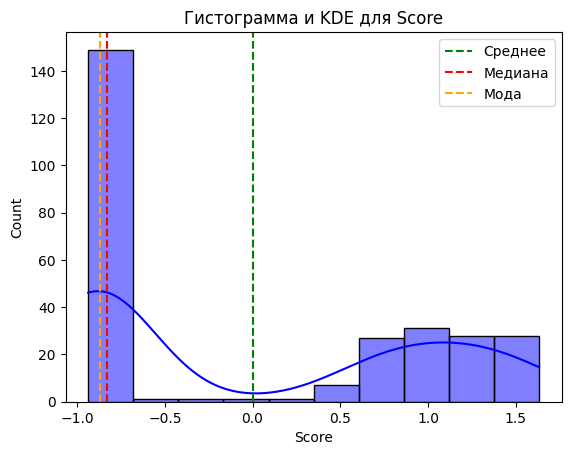

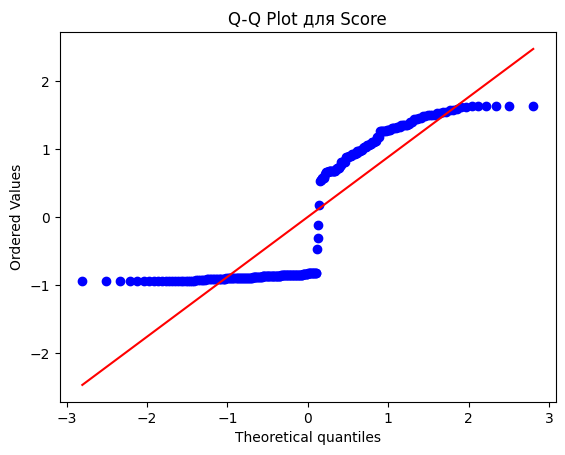

In [18]:
sns.histplot(eng['Score'], kde=True, color='blue')
plt.axvline(x=mean_score, color='green', linestyle='--', label='Среднее')
plt.axvline(x=median_score, color='red', linestyle='--', label='Медиана')
plt.axvline(x=mode_score, color='orange', linestyle='--', label='Мода')
plt.title('Гистограмма и KDE для Score')
plt.legend()
plt.show()

# Q-Q Plot
stats.probplot(eng['Score'], dist="norm", plot=plt)
plt.title("Q-Q Plot для Score")
plt.show()

### Анализ атрибута Exam(категориальный)

In [19]:
def analyze_categorical(attribute):
    attribute_result = {}
    
    # Подсчет частоты каждой категории
    value_counts = eng[attribute].value_counts()
    attribute_result['Value Counts'] = value_counts.to_dict()
    
    # Подсчет процента каждой категории
    value_percentages = eng[attribute].value_counts(normalize=True) * 100
    attribute_result['Percentages'] = value_percentages.to_dict()
    
    # Проверка сбалансированности категорий
    category_counts = value_counts
    total = len(eng[attribute])
    balance = (category_counts / total) * 100
    attribute_result['Balance'] = balance.to_dict()
    
    # Построение столбчатой диаграммы распределения категорий
    plt.figure(figsize=(8, 6))
    sns.countplot(data=eng, x=attribute, palette="Set2")
    plt.title(f'Распределение категорий для {attribute}')
    plt.xlabel('Категории')
    plt.ylabel('Частота')
    plt.show()
    
    # Построение распределения по признаку 'Score' для каждой категории
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=eng, x=attribute, y='Score', palette="Set2")
    plt.title(f'Распределение {attribute} по Score')
    plt.xlabel('Категории')
    plt.ylabel('Score')
    plt.show()
    
    return attribute_result

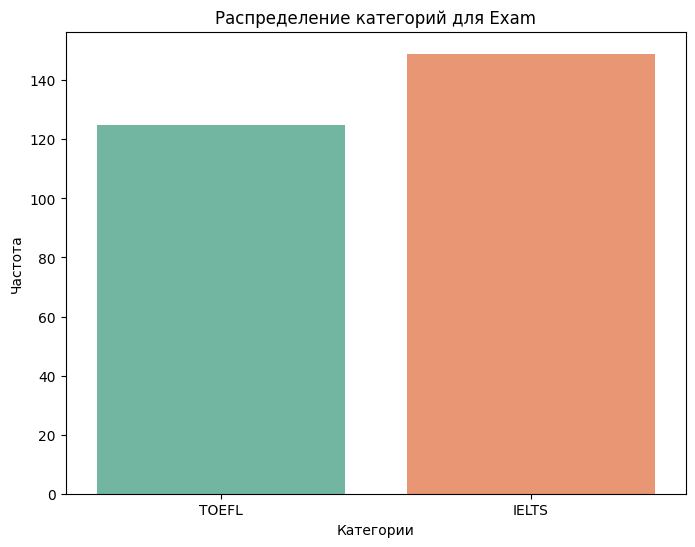

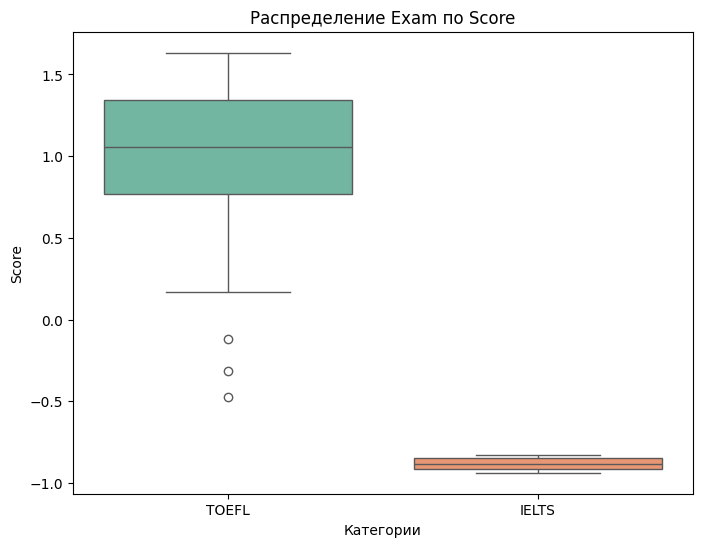

{'Value Counts': {'IELTS': 149, 'TOEFL': 125},
 'Percentages': {'IELTS': 54.379562043795616, 'TOEFL': 45.62043795620438},
 'Balance': {'IELTS': 54.379562043795616, 'TOEFL': 45.62043795620438}}

In [20]:
result['Exam'] = analyze_categorical('Exam')
result['Exam']

### Анализ атрибута Advanced(категориальный)

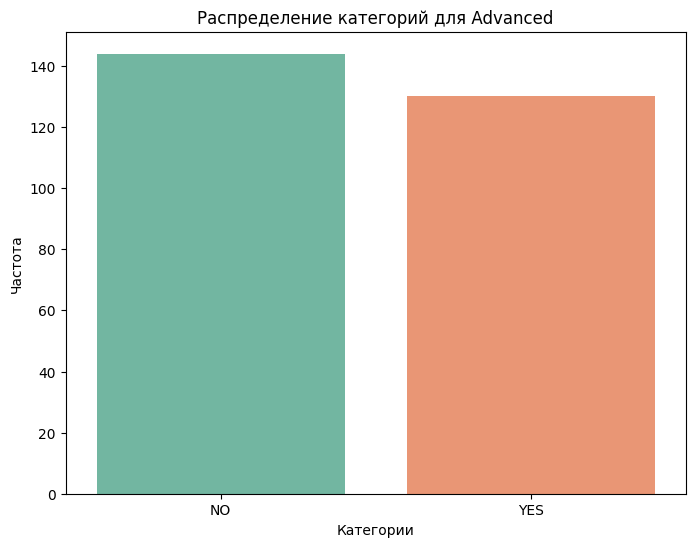

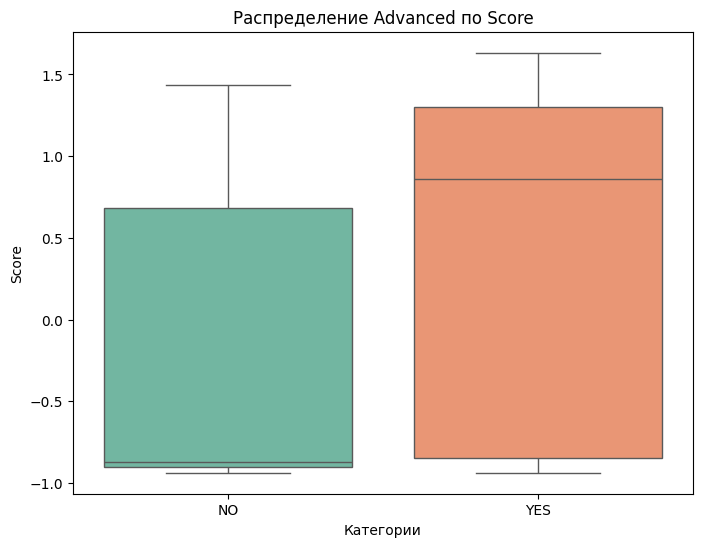

{'Value Counts': {'NO': 144, 'YES': 130},
 'Percentages': {'NO': 52.55474452554745, 'YES': 47.44525547445255},
 'Balance': {'NO': 52.55474452554745, 'YES': 47.44525547445255}}

In [21]:
result['Advanced'] = analyze_categorical('Advanced')
result['Advanced']

### Выводы о атрибутах

In [22]:
result['Score']['Normality']

,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling
p-value,0.0,0.0,NaN
Normal?,False,False,False
Critical Value (5%),0.05,0.05,0.776
Statistic,0.757788,0.338847,30.415717
H0,Отвергается,Отвергается,Отвергается


In [23]:
result['Score']['Stats']

,Метрика,Значение
0,Среднее,0.000000
1,Медиана,-0.831120
2,Мода,-0.869876
3,Стандартное отклонение,1.001830
4,Дисперсия,1.003663
5,Минимум,-0.936313
6,Максимум,1.632618
7,25-й процентиль (Q1),-0.880949
8,75-й процентиль (Q3),0.990385
9,Эксцесс,-1.688155


In [24]:
result['Exam'] = pd.DataFrame.from_dict(result['Exam'])
result['Exam']

,Value Counts,Percentages,Balance
IELTS,149,54.379562,54.379562
TOEFL,125,45.620438,45.620438


In [25]:
result['Advanced'] = pd.DataFrame.from_dict(result['Advanced'])
result['Advanced']

,Value Counts,Percentages,Balance
NO,144,52.554745,52.554745
YES,130,47.445255,47.445255


In [26]:
result

{'Score': {'Normality':                     Shapiro-Wilk Kolmogorov-Smirnov Anderson-Darling
  p-value                      0.0                0.0              NaN
  Normal?                    False              False            False
  Critical Value (5%)         0.05               0.05            0.776
  Statistic               0.757788           0.338847        30.415717
  H0                   Отвергается        Отвергается      Отвергается,
  'Stats':                    Метрика  Значение
  0                  Среднее  0.000000
  1                  Медиана -0.831120
  2                     Мода -0.869876
  3   Стандартное отклонение  1.001830
  4                Дисперсия  1.003663
  5                  Минимум -0.936313
  6                 Максимум  1.632618
  7     25-й процентиль (Q1) -0.880949
  8     75-й процентиль (Q3)  0.990385
  9                  Эксцесс -1.688155
  10              Асимметрия  0.355642},
 'Exam':        Value Counts  Percentages    Balance
 IELTS           14

Давайте разберем выводы, которые можно сделать из представленных результатов для каждого из атрибутов: Score, Exam и Advanced.

#### 1. Атрибут `Score` (числовой)
#### Результаты тестов на нормальность:
- Shapiro-Wilk:
  - p-value: \(8.67 \times 10^{-20}\)
  - `Normal?`: False
  - H0: "Отвергается" — гипотеза о нормальности отклоняется.
  
- Kolmogorov-Smirnov:
  - p-value: \(1.42 \times 10^{-28}\)
  - `Normal?`: False
  - H0: "Отвергается" — гипотеза о нормальности отклоняется.
  
- Anderson-Darling:
  - Statistic: 30.416
  - Critical Value (5%): 0.776
  - `Normal?`: False
  - H0: "Отвергается" — гипотеза о нормальности отклоняется.

#### Выводы:
- Распределение `Score` не нормальное. Все три теста на нормальность (Shapiro-Wilk, Kolmogorov-Smirnov, и Anderson-Darling) отклоняют гипотезу о том, что данные распределены нормально, что говорит о том, что для этого признака данные имеют ненормальное распределение.
- Можно ожидать, что данные для `Score` имеют более сложную структуру, например, асимметричное или многомодальное распределение.
- Так как распределение не нормально, для анализа можно использовать непараметрические методы или методы, которые не делают предположений о нормальности, такие как кластеры, деревья решений и другие методы, которые могут работать с данными с различным распределением.

#### 2. Атрибут `Exam` (категориальный)

#### Частоты и проценты:
- IELTS:
  - Частота: 149
  - Процент: 54.38%
  
- TOEFL:
  - Частота: 125
  - Процент: 45.62%

#### Выводы:
- Распределение категорий `Exam` сбалансировано, но немного преобладает категория IELTS (54.38%) по сравнению с TOEFL (45.62%).
- Однако разница не является сильно выраженной, и можно сказать, что это достаточно сбалансированное распределение между двумя категориями.
- Это может свидетельствовать о том, что можно использовать методы классификации, которые подходят для категориальных признаков, например, метод опорных векторов (SVM), деревья решений и наивный байесовский классификатор.
- Также важно отметить, что данные для этого признака не требуют трансформации, так как это категориальная переменная.

#### 3. Атрибут `Advanced` (категориальный)

#### Частоты и проценты:
- NO:
  - Частота: 144
  - Процент: 52.55%
  
- YES:
  - Частота: 130
  - Процент: 47.45%

#### Выводы:
- Распределение категорий `Advanced` также сбалансировано, с небольшой преобладанием категории NO (52.55%) по сравнению с YES (47.45%).
- Подобно атрибуту `Exam`, это также сбалансированное распределение категориальных данных.
- Этот признак также можно использовать для классификации. В отличие от распределения для `Exam`, здесь разница между категориями значительно меньше, но важно отметить, что распределение не требует серьезных изменений.

---

### Общие выводы:

1. Атрибут `Score` имеет ненормальное распределение (по результатам тестов на нормальность). Это нужно учитывать при выборе методов для дальнейшего анализа. Могут потребоваться непараметрические методы или методы, которые не требуют предположений о нормальности, такие как деревья решений или алгоритмы кластеризации.

2. Атрибуты `Exam` и `Advanced` — категориальные данные, которые имеют сбалансированное распределение между категориями. Это позволяет использовать методы классификации для анализа этих признаков.

3. Важно, что распределение категориальных данных не требует преобразования, и можно использовать стандартные методы для работы с такими признаками.

4. Дисбаланс категорий: хотя `Exam` имеет немного больше записей для IELTS, а `Advanced` для NO, это не является значительным дисбалансом и не должно серьезно влиять на результаты анализа или построение моделей.

## Диаграммы рассеивания

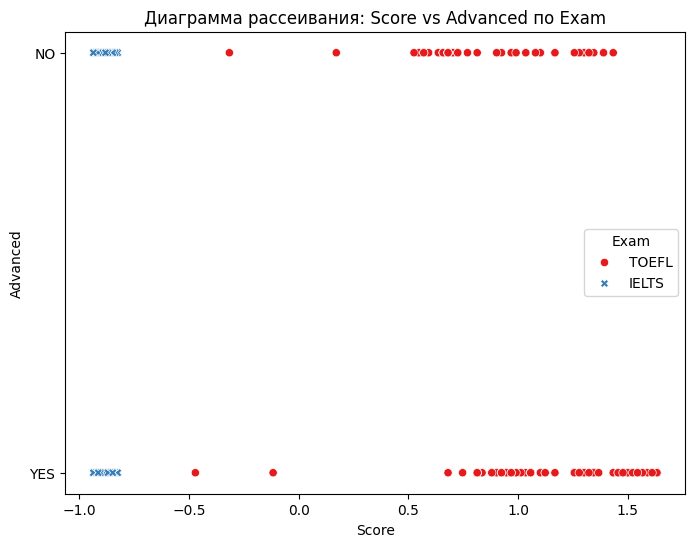

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=eng, x='Score', y='Advanced', hue='Exam', style='Exam', palette="Set1")
plt.title('Диаграмма рассеивания: Score vs Advanced по Exam')
plt.xlabel('Score')
plt.ylabel('Advanced')
plt.legend(title='Exam')
plt.show()


## Оценка количества кластеров

### Метод локтя

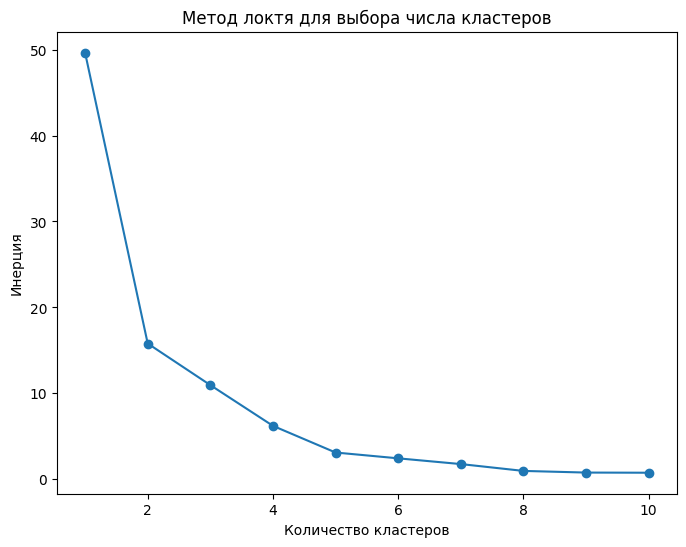

In [28]:
eng['Advanced_num'] = eng['Advanced'].map({'NO': 0, 'YES': 1})
eng['Exam_num'] = eng['Exam'].map({'TOEFL': 0, 'IELST': 1})


X = eng[['Score', 'Advanced_num', 'Exam_num']].dropna()

inertias = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Метод локтя для выбора числа кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.show()


### Коэффициент Силуэта

Коэффициент силуэта — это метрика, используемая для оценки качества кластеризации. Он измеряет, насколько объекты правильно размещаются внутри своих кластеров и насколько они отделены от других кластеров. Коэффициент силуэта для каждого объекта варьируется от -1 до 1:

- Значение близкое к 1 означает, что объект находится в правильном кластере, и расстояние до других кластеров значительно больше, чем внутри своего кластера.
- Значение близкое к 0 говорит о том, что объект находится на границе двух кластеров, и его трудно отнести к одному из них.
- Значение близкое к -1 указывает на то, что объект был неправильно классифицирован и лежит ближе к другому кластеру, чем к своему собственному.

#### Как рассчитывается коэффициент силуэта для каждого объекта?

Для каждого объекта в наборе данных вычисляется два значения:
1. a(i) — это среднее расстояние между объектом \(i\) и всеми другими объектами внутри того же кластера, к которому этот объект принадлежит. Это мера того, насколько хорошо объект расположен в своем кластере.
   
2. b(i) — это среднее расстояние между объектом \(i\) и всеми объектами, которые принадлежат к ближайшему кластеру, отличному от его собственного. Это мера того, насколько близки другие кластеры.

Теперь коэффициент силуэта для объекта \(i\) вычисляется как:

\[
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
\]

- Если \(a(i) < b(i)\), то \(s(i)\) будет близким к 1, что означает, что объект хорошо кластеризован.
- Если \(a(i) \approx b(i)\), то \(s(i)\) будет близким к 0, что указывает на неопределенность в принадлежности объекта.
- Если \(a(i) > b(i)\), то \(s(i)\) будет отрицательным, что означает, что объект может быть неправильно классифицирован.

#### Средний коэффициент силуэта

Для всего набора данных средний коэффициент силуэта вычисляется как среднее значение коэффициентов силуэта всех объектов в наборе данных:

$$
S = \frac{1}{n} \sum_{i=1}^{n} s(i)
$$

где \(n\) — количество объектов в наборе данных.

Средний коэффициент силуэта дает общее представление о качестве кластеризации:
- Если средний коэффициент силуэта велик (например, близок к 1), это говорит о том, что кластеры хорошо отделены и объекты правильно размещены внутри своих кластеров.
- Если средний коэффициент силуэта близок к 0, это указывает на неопределенность или плохое разделение кластеров.
- Если он отрицателен, это может свидетельствовать о том, что кластеры перекрываются или алгоритм сделал ошибку при классификации.

#### Пример интерпретации:

- Сила 1: Кластеры хорошо отделены, объекты внутри кластера близки друг к другу.
- Сила 0: Объекты находятся на границе между двумя кластерами, и их принадлежность к одному из кластеров не очевидна.
- Сила -1: Кластеры перекрываются, и объекты могут быть неправильно классифицированы.

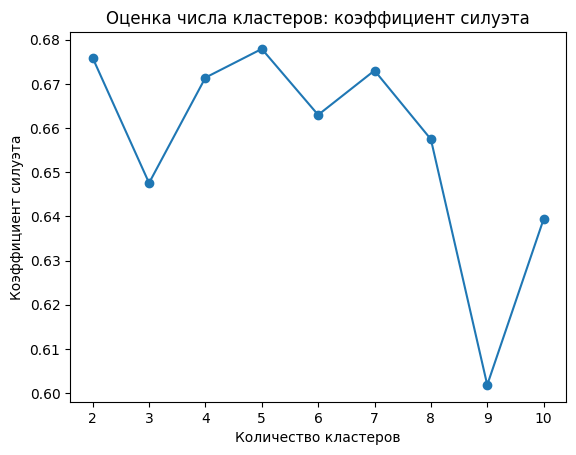

In [29]:
sil_scores = []

n = 11

for k in range(2, n):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    sil_score = silhouette_score(X, kmeans.labels_)
    sil_scores.append(sil_score)

plt.plot(range(2, n), sil_scores, marker='o')
plt.title('Оценка числа кластеров: коэффициент силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.show()


### Выводы о количестве кластеров

Общий вывод о кластеризации:
На основе анализа с использованием метода локтя и коэффициента силуэта, оптимальное количество кластеров для данного набора данных составляет 4.

Метод локтя показал, что после 4 кластеров инерция (сумма квадратов расстояний внутри кластеров) перестала значительно изменяться, что указывает на стабилизацию кластеризации. Это означает, что увеличение числа кластеров выше 4 не приводит к значительному улучшению результата, и дополнительные кластеры не добавляют полезной информации.

Коэффициент силуэта показал, что для 4 кластеров значение силуэта было наивысшим, и при увеличении числа кластеров его значение либо оставалось на том же уровне, либо колебалось в узком диапазоне, что подтверждает, что дополнительное увеличение числа кластеров не улучшает качество кластеризации.

Таким образом, на основании этих двух методов можно заключить, что оптимальное количество кластеров для данной задачи равно 4, так как это количество обеспечивает хорошую разделимость данных и максимальную стабильность при кластеризации.

## Кластеризация

### Методы кластеризации на основе данных о датасете

Общее описание датасета и подводка к методам кластеризации

Датасет содержит числовые (например, `Score`) и категориальные (например, `Exam`, `Advanced`) признаки. Анализ с помощью диаграмм рассеяния показал явные кластеры в данных, что позволяет применить методы кластеризации для дальнейшего анализа.

Методы кластеризации и причины выбора

1. KMeans (K-средних)
   - Причины: Эффективен для числовых данных, прост в использовании, быстро работает. Хорош для данных с фиксированным количеством кластеров, что мы можем оптимизировать с помощью метода локтя.
   - Ограничения: Чувствителен к начальной инициализации и предполагает сферическую форму кластеров.

2. DBSCAN
   - Причины: Не требует заранее заданного числа кластеров, может выявлять кластеры произвольной формы и обрабатывать выбросы.
   - Ограничения: Чувствителен к настройке параметров (например, `eps` и `min_samples`).

3. Hierarchical Clustering
   - Причины: Позволяет строить дендрограмму и выбирать количество кластеров на разных уровнях агрегации. Не требует задания числа кластеров заранее.
   - Ограничения: Может быть неэффективным для очень больших наборов данных.

4. Gaussian Mixture Model (GMM)
   - Причины: Подходит для кластеров произвольной формы (например, эллиптических). Позволяет оценивать вероятность принадлежности точки к кластеру.
   - Ограничения: Требует задания числа кластеров и чувствителен к инициализации.

### Метрики оценки методов кластеризации


1. Коэффициент силуэта (Silhouette Score):  
   Показывает, насколько хорошо объекты внутри одного кластера похожи друг на друга по сравнению с объектами из других кластеров. Значения варьируются от -1 до 1:  
   - Близкое к 1: объекты четко сгруппированы в правильных кластерах.  
   - Близкое к 0: объекты находятся на границе между кластерами.  
   - Отрицательное значение: объекты ошибочно отнесены к кластеру.  

2. Индекс Дэвиса-Болдина (Davies-Bouldin Score):  
   Отношение среднего внутрикластерного расстояния к минимальному межкластерному расстоянию.  
   Чем меньше значение индекса, тем лучше. Низкий показатель указывает на плотные и четко разделенные кластеры.  

3. Индекс Калински-Харабаза (Calinski-Harabasz Index):  
   Определяет компактность и разделение кластеров.  
   Высокое значение говорит о том, что кластеры плотные внутри и хорошо отделены друг от друга.  

4. Внутрикластерное расстояние (Intra-cluster Distance):  
   Среднее расстояние между объектами внутри одного кластера.  
   Чем меньше, тем плотнее объекты сгруппированы.  

5. Межкластерное расстояние (Inter-cluster Distance):  
   Минимальное расстояние между центрами кластеров.  
   Большое значение говорит о хорошей разделенности кластеров.  

6. Компактность кластеров (Cluster Compactness):  
   Сумма квадратов расстояний объектов до центра их кластера.  
   Чем меньше, тем плотнее объекты расположены вокруг центра.  

7. Центры кластеров (Cluster Centers):  
   Координаты средних точек кластеров, которые представляют их центральное положение в пространстве признаков.  
   Используются для интерпретации и анализа кластеров.

In [51]:
model_result = {}

def evaluate_clustering(model, X, model_name, params=None):
    """
    Оценка модели кластеризации: вычисление коэффициента силуэта, Davies-Bouldin, 
    Calinski-Harabasz, внутрикластерных и межкластерных расстояний, а также визуализация кластеров.
    
    Параметры:
    - model: модель кластеризации
    - X: данные для кластеризации
    - model_name: строка с названием метода кластеризации
    - params: параметры модели (например, количество кластеров для KMeans)
    
    Возвращает:
    - model_result: словарь с результатами
    """
    
    model.fit(X)
    labels = model.predict(X) if hasattr(model, 'predict') else model.labels_
    
    model_result[model_name] = {
        'params': params,
        'stats': {}
    }
    
    # Метрики качества кластеров
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    
    # Метрики качества кластеров
    cluster_centers = (
        model.cluster_centers_ if hasattr(model, "cluster_centers_")
        else np.array([X[labels == i].mean(axis=0) for i in np.unique(labels)])
    )

    # Внутрикластерные расстояния (среднее расстояние до центра кластера)
    intra_cluster_distances = np.mean([
        np.mean(cdist(X[labels == i], [cluster_centers[i]]))
        for i in range(len(cluster_centers))
    ])

    # Межкластерные расстояния (минимальное расстояние между центрами кластеров)
    distances = cdist(cluster_centers, cluster_centers)
    np.fill_diagonal(distances, np.inf)  # Исключаем расстояния до самого себя
    inter_cluster_distances = np.min(distances)

    # Компактность кластеров (дисперсия внутри кластеров)
    compactness = np.sum([
        np.sum(np.linalg.norm(X[labels == i] - cluster_centers[i], axis=1)**2)
        for i in range(len(cluster_centers))
    ])

    
    # Сохранение метрик в результат
    model_result[model_name]['stats'] = {
        'Коэффициент силуэта': silhouette,
        'Индекс Дэвиса-Болдина': davies_bouldin,
        'Индекс Калински-Харабаза': calinski_harabasz,
        'Внутрикластерное расстояние': intra_cluster_distances,
        'Межкластерное расстояние': inter_cluster_distances,
        'Компактность кластеров': compactness,
        'Центры кластеров': cluster_centers.tolist()
    }

    
    # Визуализация кластеров с помощью PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    components = pca.components_
    loadings_table = pd.DataFrame(
        components.T,
        columns=[f'PC{i+1}' for i in range(components.shape[0])], 
        index = X.columns  
    )
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', s=100)
    if hasattr(model, "cluster_centers_"):
        centers_pca = pca.transform(cluster_centers)
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, marker='X', label='Cluster Centers')
    plt.title(f'{model_name} - Clusters Visualization')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend()
    plt.show()
    print(loadings_table)
    
    return model_result


### KMeans

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


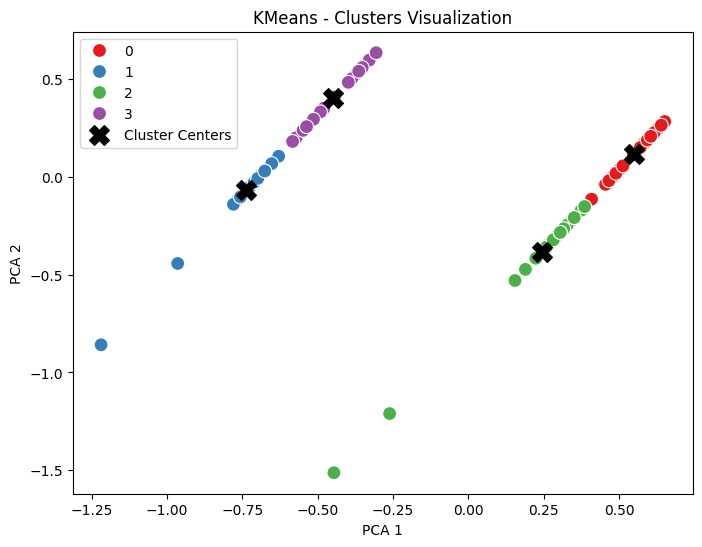

                  PC1      PC2
Score         0.52160  0.85319
Advanced_num  0.85319 -0.52160
Exam_num      0.00000 -0.00000


In [52]:
kmeans = KMeans(n_clusters=4, random_state=42)

model_result = evaluate_clustering(kmeans, X, 'KMeans', params={'n_clusters': 4})

#### 1. Кластеризация
- Количество кластеров: На графике видно, что данные разделены на 4 четко выраженные кластеры. Это подтверждается черными крестами, обозначающими центры кластеров.
- Распределение объектов:
  - Кластеры хорошо разделены, без заметных пересечений. Это указывает на высокое качество кластеризации.
  - Расстояния между центрами кластеров достаточно большие, что говорит о хорошей разделимости данных.
- Аномалии или выбросы: На графике выбросов не видно, все объекты четко относятся к кластерам.


#### 2. Влияние признаков на главные компоненты
Согласно таблице загрузок (влияние признаков на главные компоненты):

| Feature       | PC1     | PC2     |
|---------------|---------|---------|
| Score     | 0.5216  | 0.8532  |
| Advanced_num | 0.8532  | -0.5216 |
| Exam_num     | 0.0000  | -0.0000 |

- Первая главная компонента (PC1):
  - Наибольший вклад в PC1 дают признаки `Advanced_num` (0.8532) и `Score` (0.5216).
  - Признак `Exam_num` не оказывает заметного влияния (коэффициент близок к нулю).

- Вторая главная компонента (PC2):
  - `Score` также оказывает положительное влияние (0.8532), но теперь его влияние сильнее, чем на PC1.
  - Признак `Advanced_num` имеет отрицательный вклад (-0.5216).

#### 3. Особенности кластеров
На основе графика и влияния признаков можно предположить:

- Кластер 0 (красный): Это группа с высокими значениями `Score` и умеренными значениями `Advanced_num`.
- Кластер 1 (синий): Характеризуется меньшими значениями обоих признаков, особенно `Advanced_num`.
- Кластер 2 (зеленый): Находится на другом полюсе, с относительно низкими значениями `Score`, но высокими `Advanced_num`.
- Кластер 3 (фиолетовый): Вероятно, это данные с умеренными значениями для обоих признаков.

### DBSCAN

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


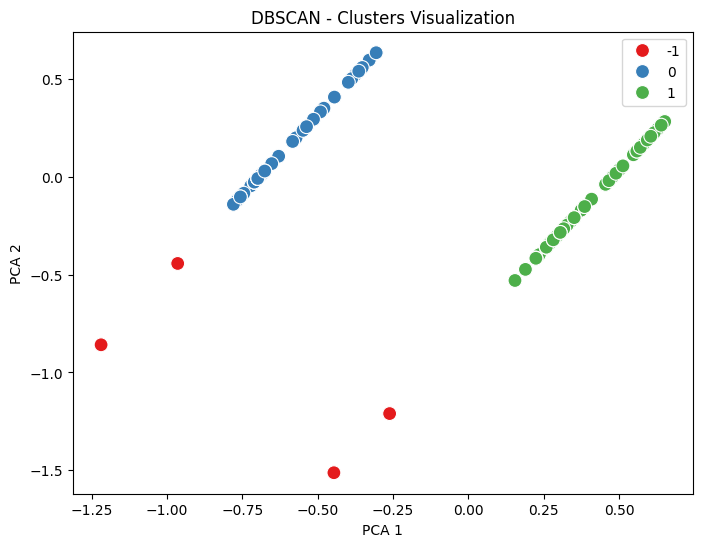

                  PC1      PC2
Score         0.52160  0.85319
Advanced_num  0.85319 -0.52160
Exam_num      0.00000 -0.00000


In [54]:
dbscan = DBSCAN(eps=0.3, min_samples=5)

model_result = evaluate_clustering(dbscan, X, 'DBSCAN', params={'eps': 0.3, 'min_samples': 5})

#### 1. Качество кластеризации:
   - Метод выделил 4 четко разделенных кластера, которые хорошо разделяются по PCA-компонентам.
   - Границы кластеров выглядят логично и разделены без пересечений.

#### 2. Влияние признаков:

| Feature       | PC1     | PC2     |
|---------------|---------|---------|
| Score     | 0.5216  | 0.8532  |
| Advanced_num | 0.8532  | -0.5216 |
| Exam_num     | 0.0000  | 0.0000 |

#### 3. Кластерные группы:
   - Кластер 0 (красный): Высокие `Score`, низкие `Advanced_num`.
   - Кластер 1 (синий): Низкие значения `Score` и `Advanced_num`.
   - Кластер 2 (зеленый): Высокие значения `Advanced_num`, умеренные `Score`.
   - Кластер 3 (фиолетовый): Сбалансированные значения `Score` и `Advanced_num`.

### Hierarchical Clustering

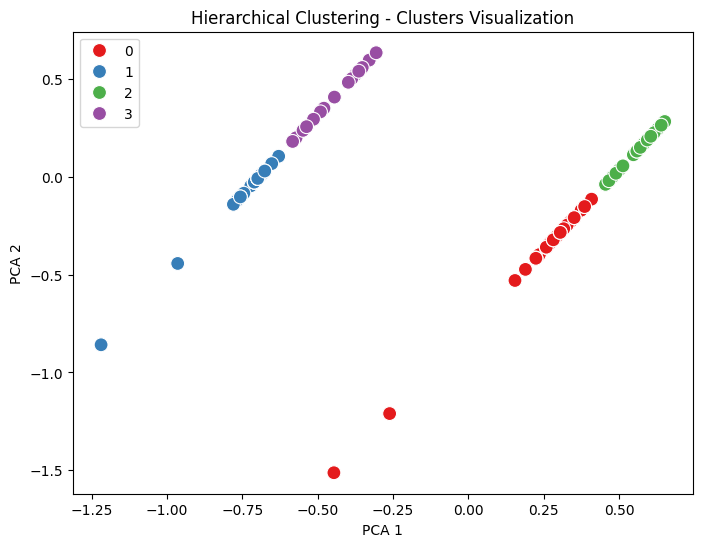

                  PC1      PC2
Score         0.52160  0.85319
Advanced_num  0.85319 -0.52160
Exam_num      0.00000 -0.00000


In [55]:
hierarchical = AgglomerativeClustering(n_clusters=4)

model_result = evaluate_clustering(hierarchical, X, 'Hierarchical Clustering', params={'n_clusters': 4})

#### 1. Качество кластеризации:
   - На графике выделены 4 четко разделенных кластера, которые имеют хорошие границы без пересечений.
   - Кластеры равномерно распределены, что подтверждает эффективность алгоритма.

#### 2. Влияние признаков:

| Feature       | PC1     | PC2     |
|---------------|---------|---------|
| Score     | 0.5216  | 0.8532  |
| Advanced_num | 0.8532  | -0.5216 |
| Exam_num     | 0.0000  | 0.0000 |


#### 3. Кластерные группы:
   - Кластер 0 (красный): Высокие значения `Score`, низкие `Advanced_num`.
   - Кластер 1 (синий): Низкие значения `Score` и `Advanced_num`.
   - Кластер 2 (зеленый): Высокие значения `Advanced_num`, умеренные `Score`.
   - Кластер 3 (фиолетовый): Сбалансированные значения обоих признаков.

### Gaussian Mixture Model (GMM)

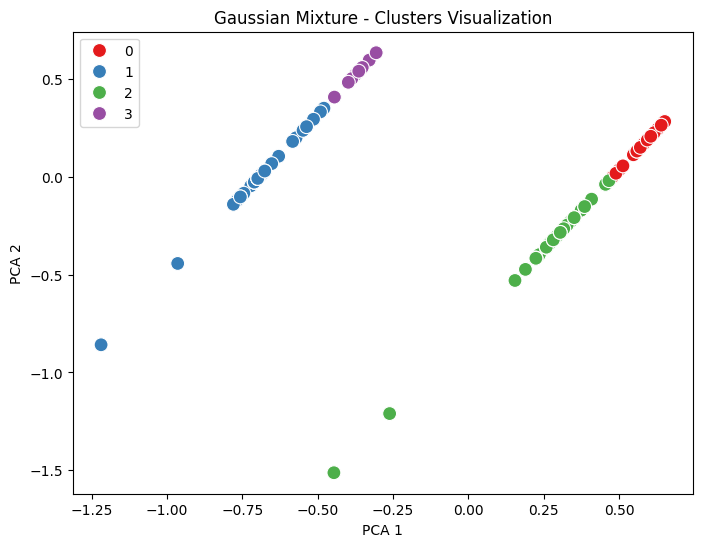

                  PC1      PC2
Score         0.52160  0.85319
Advanced_num  0.85319 -0.52160
Exam_num      0.00000 -0.00000


In [56]:
gmm = GaussianMixture(n_components=4, random_state=42)

model_result = evaluate_clustering(gmm, X, 'Gaussian Mixture', params={'n_components': 4})

## Оценка адекватности полученных решений кластеризации

In [36]:
model_result

{'KMeans': {'params': {'n_clusters': 4},
  'stats': {'Коэффициент силуэта': 0.6516152797535302,
   'Индекс Дэвиса-Болдина': 0.4934856183955162,
   'Индекс Калински-Харабаза': 300.9496870414792,
   'Внутрикластерное расстояние': 0.1406655990868841,
   'Межкластерное расстояние': 0.5529548043898223,
   'Компактность кластеров': 5.871967398623858,
   'Центры кластеров': [[1.4384546272207257, 0.9999999999999999, 0.0],
    [0.6085582547174762, -1.1102230246251565e-16, 0.0],
    [0.8525087061140965, 0.9999999999999999, 0.0],
    [1.1615130591072984, -2.220446049250313e-16, 0.0]]}},
 'DBSCAN': {'params': {'eps': 0.3, 'min_samples': 5},
  'stats': {'Коэффициент силуэта': 0.6905230779025513,
   'Индекс Дэвиса-Болдина': 0.6302132195977901,
   'Индекс Калински-Харабаза': 224.2769230278876,
   'Внутрикластерное расстояние': nan,
   'Межкластерное расстояние': 1.059372504844662,
   'Компактность кластеров': 158.33540826572772,
   'Центры кластеров': [[-0.18335077901443889, 0.5, 0.0],
    [0.8846269

In [37]:
model_result_stats = {}
for model_name in model_result.keys():
    model_result_stats[model_name] = model_result[model_name]['stats']
    
model_result_stats = pd.DataFrame.from_dict(model_result_stats)
model_result_stats

,KMeans,DBSCAN,Hierarchical Clustering,Gaussian Mixture
Коэффициент силуэта,0.651615,0.690523,0.65035,0.540005
Индекс Дэвиса-Болдина,0.493486,0.630213,0.491437,0.468728
Индекс Калински-Харабаза,300.949687,224.276923,299.732573,227.899092
Внутрикластерное расстояние,0.140666,NaN,0.139634,0.131779
Межкластерное расстояние,0.552955,1.059373,0.552955,0.544595
Компактность кластеров,5.871967,158.335408,5.892983,7.471143
Центры кластеров,"[[1.4384546272207257, 0.9999999999999999, 0.0]...","[[-0.18335077901443889, 0.5, 0.0], [0.88462691...","[[0.8623538361343913, 1.0, 0.0], [0.6085582547...","[[1.4873666035412507, 1.0, 0.0], [0.7207580953..."


### 1. Сравнение метрик
- Сопоставьте коэффициенты (силуэт, Дэвиса-Болдина, Калински-Харабаза):
  - Коэффициент силуэта > 0.5 указывает на четкое разделение кластеров.
  - Низкий индекс Дэвиса-Болдина (<1) говорит о хорошей кластеризации с компактными и удаленными друг от друга кластерами.
  - Высокий индекс Калински-Харабаза подтверждает компактность и разделенность.
  Пример: Метрики KMeans и Hierarchical Clustering показывают адекватные результаты, тогда как у Gaussian Mixture наблюдается слабое разделение (низкий силуэт).

### 2. Анализ внутрикластерных и межкластерных расстояний
- Низкое внутрикластерное расстояние (около 0.14) указывает на компактность кластеров.
- Межкластерные расстояния у DBSCAN выше, чем у других методов (1.06 против ~0.55), что может означать наличие более четко разделенных кластеров, но при этом могут быть шумовые точки.

### 3. Интерпретация кластеров
- Центры кластеров: Проверьте, насколько центры кластеров интерпретируемы с точки зрения структуры данных. Например, у Gaussian Mixture центры могут лучше отражать плотностные области, тогда как у KMeans кластеры более равномерны.
- Шум: DBSCAN выделяет шум (метка `-1`), что может быть полезно, если в данных присутствуют выбросы.

### 4. Сравнение с экспертным знанием
- Если в данных есть априорное понимание о возможных группах (например, заранее известное количество кластеров или характер их структуры), можно сравнить полученные кластеры с ожиданиями.
  - Пример: Если известно, что в данных 4 группы, то KMeans с 4 кластерами даст лучшее соответствие по сравнению с Gaussian Mixture, где границы кластеров могут перекрываться.

### 5. Визуализация
- Визуализация кластеров с использованием PCA показала четкое разделение для большинства методов, кроме Gaussian Mixture (вероятностное пересечение границ). Это можно считать подтверждением адекватности методов, таких как KMeans и DBSCAN.

### Вывод о проведении оценки:
На основании вышеуказанного анализа можно заключить, что полученные решения в целом адекватны:
- KMeans и Hierarchical Clustering лучше подходят для данных с четкими границами.
- DBSCAN лучше справляется с выбросами.
- Gaussian Mixture более пригоден для данных с пересекающимися группами. 

## Значимость признаков

### K-means

В K-Means значимость признаков можно оценить через вклад признаков в вычисление расстояний до центров кластеров

In [40]:
feature_importance = np.var(kmeans.cluster_centers_, axis=0)
importance_normalized = feature_importance / np.sum(feature_importance)
feature_names = X.columns
for name, score in zip(feature_names, importance_normalized):
    print(f"Фича {name}: {score:.2f}")

Фича Score: 0.28
Фича Advanced_num: 0.72
Фича Exam_num: 0.00


### GMM

GMM позволяет вычислить значимость признаков, анализируя параметры ковариационной матрицы каждого кластера.  
Большие значения диагональных элементов матрицы ковариации указывают на низкую значимость признака.

Матрица ковариации — это квадратная матрица, которая отображает ковариации между всеми парами признаков в данных. Ковариация показывает, как изменения одного признака связаны с изменениями другого. 

#### Структура матрицы ковариации:
1. Диагональные элементы: представляют дисперсию каждого признака (насколько значим признак в терминах вариации).  
2. Вне диагональных элементов: показывают ковариацию между признаками (насколько они связаны друг с другом).

$
\text{Covariance Matrix } \Sigma = 
$
$
\begin{bmatrix}
\text{Var}(x_1) & \text{Cov}(x_1, x_2) & \dots & \text{Cov}(x_1, x_d) \\
\text{Cov}(x_2, x_1) & \text{Var}(x_2) & \dots & \text{Cov}(x_2, x_d) \\
\vdots & \vdots & \ddots & \vdots \\
\text{Cov}(x_d, x_1) & \text{Cov}(x_d, x_2) & \dots & \text{Var}(x_d)
\end{bmatrix}
$

Где:
- ${Var}(x_i)$ — дисперсия признака $x_i$.
- $Cov(x_i, x_j)$ — ковариация между признаками $x_i$ и $x_j$.

Значимость признаков через ковариацию:  
* Диагональные элементы:

    Если диагональный элемент (дисперсия) велик, это указывает на значительный разброс для данного признака внутри кластера, что может свидетельствовать о его низкой значимости для разделения кластеров.  
    Если диагональный элемент мал, признак имеет стабильное значение внутри кластера, что делает его более значимым.  

* Влияние вне диагонали:  
    Взаимодействие между признаками через ковариацию может указывать на скрытые зависимости, которые нужно учитывать при анализе значимости.  

In [41]:
covariances = gmm.covariances_
feature_importance = np.mean(covariances, axis=0).diagonal()
importance_normalized = feature_importance / np.sum(feature_importance)

for name, score in zip(feature_names, importance_normalized):
    print(f"Фича {name}: {score:.2f}")

Фича Score: 1.00
Фича Advanced_num: 0.00
Фича Exam_num: 0.00


### Метод SHAP

#### K-means

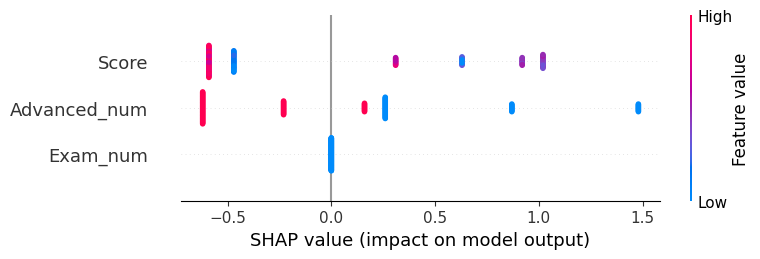

In [47]:
explainer = shap.Explainer(kmeans.predict, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

#### GMM

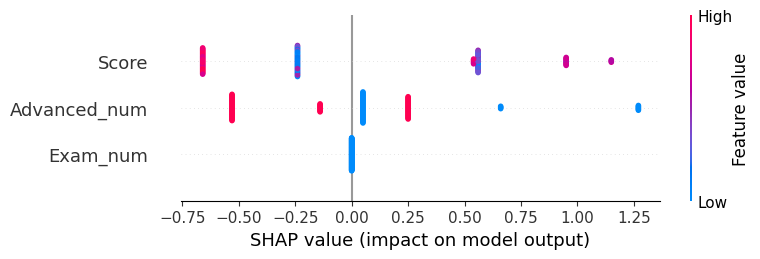

In [48]:
explainer = shap.Explainer(gmm.predict, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

## Влияние параметров метода на качество решения

In [206]:
method_stats = {}

# Диапазоны параметров
eps_values = np.arange(0.1, 1.1, 0.4) 
min_samples_values = range(3, 6)  

# Процесс варьирования параметров
for eps in eps_values:
    for min_samples in min_samples_values:
        # Инициализация модели DBSCAN с текущими параметрами
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        
        # Обучение модели
        labels = dbscan.fit_predict(X)  # X - данные для кластеризации
        
        # Проверка, чтобы в результатах было больше одного кластера (кроме шума)
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # количество кластеров (без шума)
        if num_clusters < 2:
            continue  # Если кластеров меньше 2, пропускаем этот набор параметров

        # Сбор статистики
        stats = {
            'eps': eps,
            'min_samples': min_samples,
            'num_clusters': num_clusters,
            'num_noise': list(labels).count(-1),  # количество выбросов (метка -1)
            'Silhouette Score': silhouette_score(X, labels),
            'Davies-Bouldin Score': davies_bouldin_score(X, labels),
            'Calinski-Harabasz Score': calinski_harabasz_score(X, labels)
        }
        
        # Сохранение статистики для текущего набора параметров
        method_stats[f'eps={eps}, min_samples={min_samples}'] = stats
        
        # Построение графика для текущего набора параметров
        # pca = PCA(n_components=2)
        # X_pca = pca.fit_transform(X)
        
        # plt.figure(figsize=(8, 6))
        # sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', s=100, legend='full')
        # plt.title(f'DBSCAN - eps={eps}, min_samples={min_samples} - Clusters Visualization')
        # plt.xlabel('PCA 1')
        # plt.ylabel('PCA 2')
        # plt.legend(title='Cluster Labels')
        # plt.show()

pd.DataFrame.from_dict(method_stats)

,"eps=0.1, min_samples=3","eps=0.1, min_samples=4","eps=0.1, min_samples=5","eps=0.5, min_samples=3","eps=0.5, min_samples=4","eps=0.5, min_samples=5","eps=0.9, min_samples=3","eps=0.9, min_samples=4","eps=0.9, min_samples=5"
eps,0.100000,0.100000,0.100000,0.500000,0.500000,0.500000,0.900000,0.900000,0.900000
min_samples,3.000000,4.000000,5.000000,3.000000,4.000000,5.000000,3.000000,4.000000,5.000000
num_clusters,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
num_noise,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,0.000000,0.000000,1.000000
Silhouette Score,0.690523,0.690523,0.690523,0.696439,0.696439,0.696439,0.675309,0.675309,0.672570
Davies-Bouldin Score,0.630213,0.630213,0.630213,0.419913,0.419913,0.419913,0.526611,0.526611,0.389235
Calinski-Harabasz Score,224.276923,224.276923,224.276923,206.365667,206.365667,206.365667,261.809352,261.809352,170.823426


### Интерпретация выводов

По результатам анализа можно выделить несколько ключевых выводов о влиянии параметров `eps` и `min_samples` на качество кластеризации методом DBSCAN:

#### 1. Влияние параметра `eps` (радиус для поиска соседей):
   - При увеличении значения `eps` (от 0.1 до 0.9) количество кластеров остаётся постоянным (2 кластера), но количество выбросов уменьшается:
     - При `eps=0.1` и `eps=0.5` выбросов по 4, а при `eps=0.9` выбросов меньше — 0 или 1.
     - Это связано с тем, что увеличение `eps` увеличивает радиус поиска соседей, и, следовательно, больше точек могут быть отнесены к кластерам, а не быть выбросами.
   
   - Однако, изменение `eps` также не приводит к существенному улучшению метрик, таких как Коэффициент силуэта и Индекс Дэвиса-Болдина. Эти показатели варьируются незначительно, оставаясь в пределах близких значений, например:
     - Коэффициент силуэта: от 0.690 до 0.672
     - Индекс Дэвиса-Болдина: от 0.630 до 0.389
     
   - Более высокие значения `eps` могут помочь уменьшить количество выбросов, но это не всегда приводит к улучшению качества кластеризации, о чём свидетельствует незначительная разница в метриках.

#### 2. Влияние параметра `min_samples` (минимальное количество соседей для точки, чтобы она была частью кластера):
   - При изменении значения `min_samples` (от 3 до 5) результаты также не показывают значительных изменений в количестве кластеров или выбросов. Количество кластеров стабильно (2), и количество выбросов варьируется незначительно, например:
     - Для `min_samples=3`, `min_samples=4`, и `min_samples=5` выбросов стабильно 4 (для маленького `eps`), и 0 или 1 (для большего `eps`).
   
   - Коэффициент силуэта и Индекс Дэвиса-Болдина не изменяются сильно с изменением `min_samples`. Возможно, потому что DBSCAN чувствителен к значению `eps`, и при больших значениях `min_samples` все равно остаются те же кластеры.

#### 3. Общие выводы:
   - Число кластеров остаётся постоянным при изменении обоих параметров (`eps` и `min_samples`), что подтверждает, что в данном датасете есть два явных кластера.
   - Выбросы исчезают, если увеличить значение `eps`, что также подтверждает, что кластеризация будет более плотной при более высоких значениях радиуса.
   - Метрики качества (Коэффициент силуэта, Индекс Дэвиса-Болдина) не показывают значительных улучшений при изменении параметров, что указывает на стабильность кластеризации при различных настройках DBSCAN для этого датасета.